# Main Notebook of Milestone 1 Presentation

In [1]:
__author__ = "Josh Fisher, Nick Bermudez, Zhou Jiang"

In [2]:
import os
import json
import pandas as pd
from visualizations import Visualizations

## Data Source

We were interested in two of the CDC's National Health and Nutrition Examination Survey (NHANES) datasets. Specifically, the demographics dataset [(link)](https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=Demographics&Cycle=2017-2020) and the total nutrient intakes dataset [(link)](https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=Dietary&Cycle=2017-2020).

The demographics survery asks questions regarding demographic factors such as pregnancy status, ratio of family income to poverty, and "other selected demographic information, such as gender, age, race/Hispanic origin, education, marital status, country of birth, and years of U.S. residence." [source](https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/P_DEMO.htm)

"The objective of the dietary interview component is to obtain detailed dietary intake information from NHANES participants. The dietary intake data are used to estimate the types and amounts of foods and beverages (including all types of water) consumed during the 24-hour period prior to the interview (midnight to midnight), and to estimate intakes of energy, nutrients, and other food components from those foods and beverages." [source](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DR1TOT_I.htm)

We were able to scrape all available years for both datasets but opted to use only the most recent report as we were interested in current health trends. You can check out the webscraping script at [Scripts/webscrape.py](webscrape.py)

The format of each dataset is .xpt and the variable names are encoded. Data is stored in Data/Final/*.xpt and data dictionaries mapping encoded_var: var can be found in same directory

In [3]:
class NHANESDataFrame:
    """ This class is specific to NHANES dataset and contains cleaning functions, utilities, etc. """
    def __init__(self, path):
        self.path = path

    def clean_demographics_df(self):
        """ returns cleaned, renamed, demographics dataframe """
        demo_d = self.get_demographics_dict()
        df = pd.read_sas(self.path)

        # filter, only include cols in demo_d.keys()
        df = df[list(demo_d.keys())]

        # rename to demo_d.valuese()
        df = df.rename(columns=demo_d)

        # Removing rows where all values are NaN
        temp = list(demo_d.values())
        temp.remove('id')
        return df

    def clean_total_nutrients_df(self):
        """ returns cleaned, renamed, total nutrients dataframe """
        d = {'SEQN': 'id'}
        macro_d = self.get_macronutrient_dict()
        ess_d = self.get_essential_vitamins_dict()
        oth_d = self.get_other_nutrients_dict()

        d.update(macro_d)
        d.update(ess_d)
        d.update(oth_d)

        df = pd.read_sas(self.path)

        # filter
        df = df[list(d.keys())]
        # rename
        df = df.rename(columns=d)
        return df

    @staticmethod
    def read_combine_clean_demographics_total_nutrients(demographics_path, total_nutrients_path):
        """ Reads demographics and total nutrients, clean both, and merge the two dataframe together """
        demo_df = NHANESDataFrame(demographics_path).clean_demographics_df()
        nuts_df = NHANESDataFrame(total_nutrients_path).clean_total_nutrients_df()
        df = demo_df.merge(nuts_df, on='id')
        return df

    @staticmethod
    def get_essential_vitamins_dict():
        """
        https://www.nia.nih.gov/health/vitamins-and-supplements/vitamins-and-minerals-older-adults#:~:text=There%20are%2013%20essential%20vitamins,keep%20the%20body%20working%20properly.
        There are 13 essential vitamins —
        vitamins A, C, D, E, K,
        and the B vitamins (thiamine, riboflavin, niacin, pantothenic acid, biotin, B6, B12, and folate).

        no pantothenic acid in NHANES
        no biotin in NHANES

        :return:
            encoded_var: var
        """
        d = {
            "DR1TVARA": 'vitaminA', "DR1TVC": "vitaminC", "DR1TVD": "vitaminD", "DR1TATOC": 'vitaminE', "DR1TVK": "vitaminK",
            "DR1TVB1": 'thiamine', "DR1TVB2": "riboflavin", "DR1TNIAC": 'niacin', "DR1TVB6": "vitaminB6",
            "DR1TVB12": "vitaminB12", "DR1TFOLA": "folate"
        }
        return d

    @staticmethod
    def get_macronutrient_dict() -> dict:
        """
        Common macronutrients
        :return:
            encoded_var: var
        """
        d = {"DR1TKCAL": "kcals", "DR1TPROT": "protein", "DR1TCARB": "carbs", "DR1TSUGR": "sugar",
            "DR1TTFAT": "total_fat", "DR1TSFAT": "sat_fat", "DR1TMFAT": "mono_fat", "DR1TPFAT": "poly_fat",
            "DR1TCHOL": "cholesterol"}
        return d

    @staticmethod
    def get_other_nutrients_dict() -> dict:
        d = {"DR1TCALC": "calcium", "DR1TPHOS": "phosphorus", "DR1TMAGN": "magnesium",
             "DR1TIRON": "iron", "DR1TZINC": "zinc", "DR1TCOPP": "copper", "DR1TSODI": "sodium",
             "DR1TPOTA": "potassium", "DR1TSELE": "selenium", "DR1TCAFF": "caffeine",
             "DR1TTHEO": "theobromine", "DR1TALCO": "alcohol"}
        return d

    @staticmethod
    def get_demographics_dict() -> dict:
        with open('../Data/Final/demographics.json') as f:
            d = json.load(f)
        return d

    @staticmethod
    def get_bins_dict():
        d = {
            'income_poverty': [0, 1, 2, 3, 4, 4.99, 5],
            'age_yrs': [0, 2, 13, 20, 30, 40, 50, 60, 70, 79.99, 80]
        }
        return d

    @staticmethod
    def get_sparse_to_cat_dict():
        d = {
            'gender': {1: "Male", 2: "Female"},
            'race': {1: "Mexican American", 2: "Other Hispanic", 3: "Non-Hispanic White",
                     4: "Non-Hispanic Black", 5: "Other"},
            'education': {1: "<9th Grade", 2: "9-11th Grade", 3: "High School", 4: "Some College",
                          5: ">College", 7: "Refused", 9: "Don\'t Know"},
            'pregnant': {1: "Pregnant", 2: "Not Pregnant", 3: "Uncertain"},
            'country_born': {1: "USA", 2: "Other", 77: "Refused", 99: "Don\'t Know"},
            'married': {1: "Married", 2: "Separated", 3: "Never Married", 77: "Refused", 99: "Don\'t Know"},
            'time_in_us': {1: "<5 Yrs", 2: "5-15 Yrs", 3: "15-30 Yrs", 4: ">30 Yrs", 77: "Refused", 99: "Don\'t Know"}
        }
        return d

    @staticmethod
    def sparse_col_to_str(df, cols=None):
        """
        Converts a sparse encoded col(s) to str representation. Uses rename_dict for mapping
        :param cols:
            - If None: uses all keys in rename_dict()
            - If list of col names: uses those column names
            - If string: use single col name
        :return:
            NhanesDF with new df vals
        """
        assert cols is None or type(cols) == list or type(cols) == str, "cols must either be None, list, or str"

        d = NHANESDataFrame.get_sparse_to_cat_dict()

        if type(cols) == str:
            cols = [cols]
        if type(cols) == list:
            mapped_keys = set(d.keys())
            if len(set(cols) - mapped_keys) > 0:
                print(f"Dont have mappings for: {set(cols) - mapped_keys}")
            d = {k: v for k, v in d.items() if k in cols}

        new_df = df.replace(d)
        return new_df



Going from raw XPTs to cleaned csv is resource intensive (the fully concatenated demographics dataframe of all years is more than a gigabyte). As well as involving Webscraping with Selenium which is dependent on the user's operating system, version of web-browser, permissions, etc. So we have provided convenient functions to access cleaned demographics, total nutrients, and combined dataframes

In [4]:
def get_demographics_df():
    """ Convenient function to get cleaned demographics dataframes"""
    df = pd.read_csv("../Data/Final/demographics_clean.csv")
    return df

def get_total_nutrients_df():
    """ Convenient function to get cleaned total nutrients dataframes"""
    df = pd.read_csv("../Data/Final/total_nutrients_clean.csv")
    return df

def get_combined_df():
    """ Convenient function to get cleaned and combined demographics and total nutrient file """
    df = pd.read_csv('../Data/Final/nhanes.csv')
    return df.loc[df.year == 2020]



## Exploratory Data Analysis (EDA)

Our first step was exploratory data analysis. Each team member performed their own EDA and we shred findings along the way.

### Josh EDA

In the past. I have had the most luck looking at the various distributions of variables, the distribution of variables among different subgroups, and two-dimensional distributions.

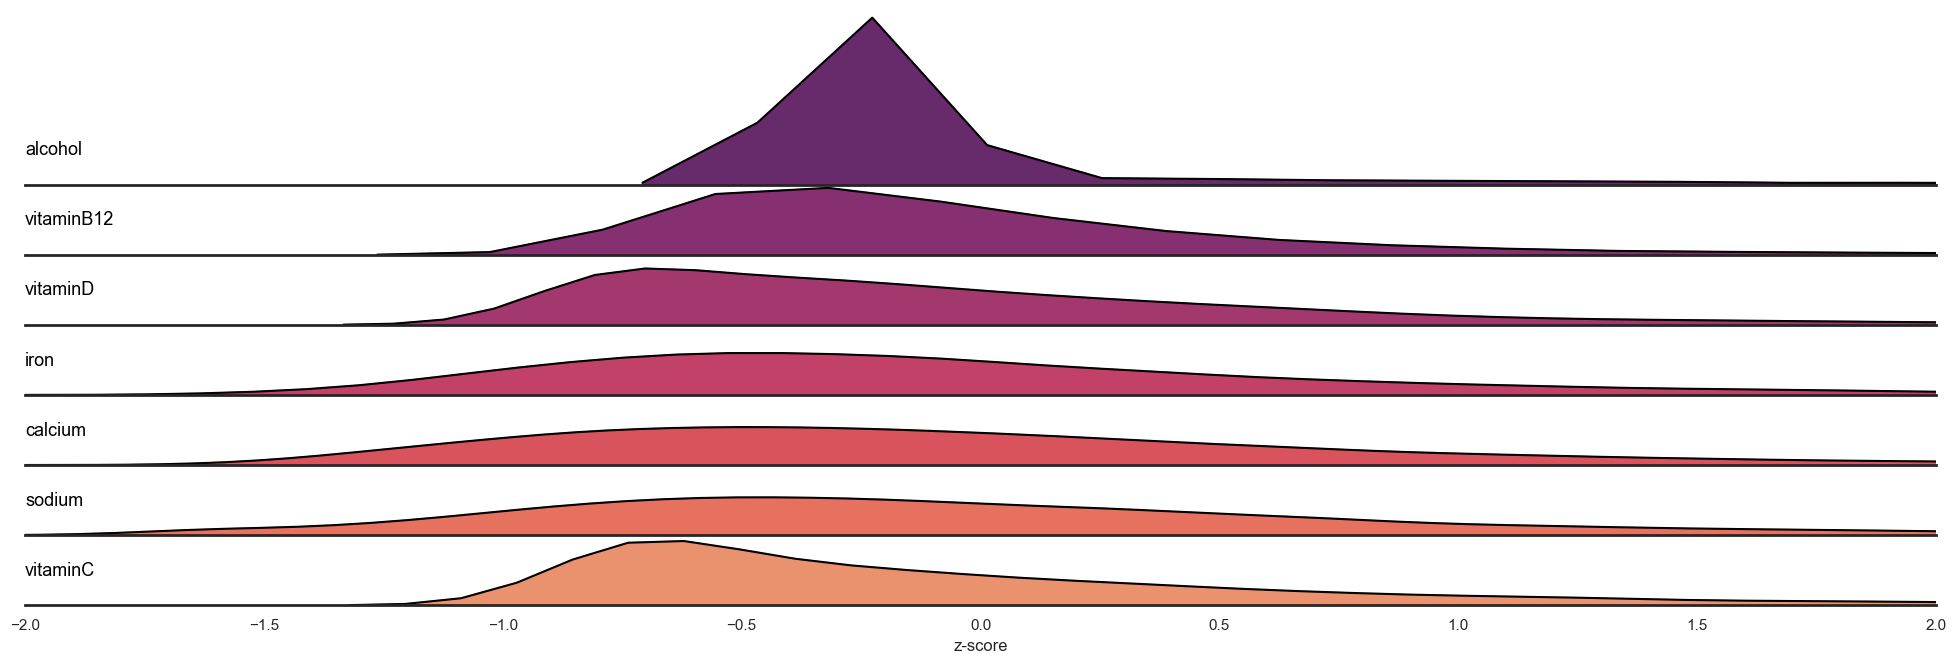

In [8]:
def plot_distributions_ridgeplot():
    vars = ['alcohol', 'vitaminD', 'vitaminC', 'vitaminB12', 'calcium', 'sodium', 'iron']
    df = get_combined_df()
    df = df[vars]
    xlim = (-2, 2)
    Visualizations.ridgeplot(df, xlim=xlim)

def plot_iron_sodium_joint_grid():
    df = get_combined_df()
    x = 'iron'
    y = 'sodium'
    xlim = (0, 50)
    ylim = (0, 10000)
    Visualizations().joint_grid_2dkde_marg_hist(df, x, y, xlim, ylim)

def plot_calcium_male_female_violin():
    df = get_combined_df()
    df = NHANESDataFrame.sparse_col_to_str(df, 'gender')
    df['age_yrs_binned'] = pd.cut(df['age_yrs'], [0, 20, 50, 79.9, 150], labels=["0-20", "20-50", "50-80", "80+"])

    x = 'age_yrs_binned'
    y = 'calcium'
    hue = 'gender'
    ylim = (-100, 3500)

    Visualizations.violin_plot_calcium(df, x, y, hue, ylim)

plot_distributions_ridgeplot()

In [16]:
# TODO: Add Nick EDA

In [17]:
# TODO: Add Zhou EDA